In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

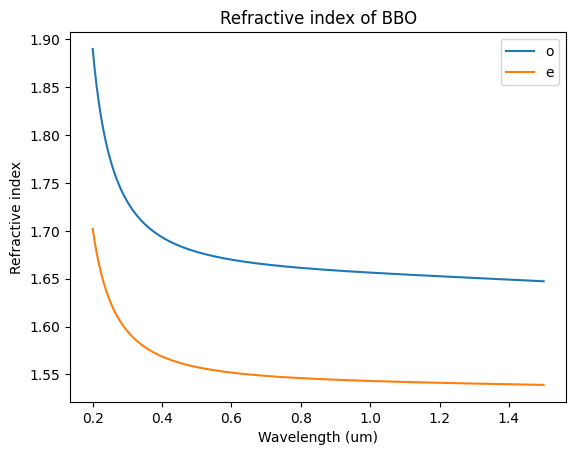

In [24]:
def bbo_sellmeier_n(wavelength, axis='o'):
    """
    Sellmeier equation for BBO crystal
    https://refractiveindex.info
    Eimerl et al., 1987
    """
    if axis == 'o':
        A = 2.7405
        B = 0.0184
        C = 0.0179
        D = 0.0155
    elif axis == 'e':
        A = 2.3730
        B = 0.0128
        C = 0.0156
        D = 0.0044

    n2 = A + B / (wavelength**2 - C) - D * wavelength**2
    return np.sqrt(n2)

# plot the refractive index of BBO 
wavelength = np.linspace(0.2, 1.5, 1000)
n_o = bbo_sellmeier_n(wavelength, 'o')
n_e = bbo_sellmeier_n(wavelength, 'e')
plt.plot(wavelength, n_o)
plt.plot(wavelength, n_e)
plt.legend(['o', 'e'])
plt.xlabel('Wavelength (um)')
plt.ylabel('Refractive index')
plt.title('Refractive index of BBO')
plt.show()

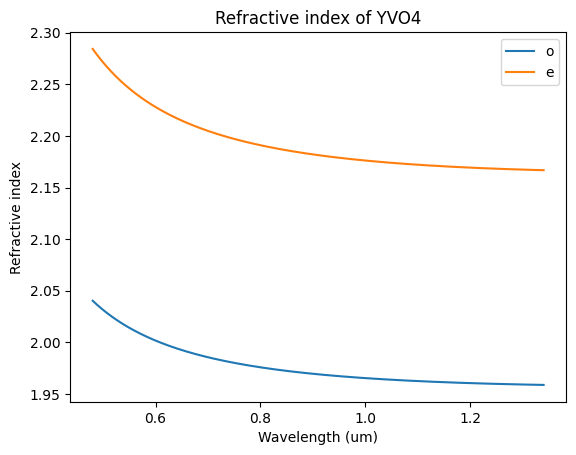

In [25]:
def yvo_sellmeier_n(wavelength, axis='o'):
    """
    Sellmeier equation for YVO4 crystal
    https://refractiveindex.info
    Shi et al. (2001) (20 °C)
    """
    if axis == 'o':
        A = 3.778790
        B = 0.070479
        C = 0.045731
        D = -0.009701
    elif axis == 'e':
        A = 4.607200
        B = 0.108087
        C = 0.052495
        D = -0.014305
    n2 = A + B / (wavelength**2 - C) - D * wavelength**2
    return np.sqrt(n2)

# plot the refractive index of YVO4
wavelength = np.linspace(0.48, 1.34, 1000)
n_o = yvo_sellmeier_n(wavelength, 'o')
n_e = yvo_sellmeier_n(wavelength, 'e')
plt.plot(wavelength, n_o)
plt.plot(wavelength, n_e)
plt.legend(['o', 'e'])
plt.xlabel('Wavelength (um)')
plt.ylabel('Refractive index')
plt.title('Refractive index of YVO4')
plt.show()

In [26]:
def get_phase(n, thickness, wavelength):
    return 2 * np.pi * n * thickness / wavelength

def bbo_sellmeier_n_eff(wavelength, theta=np.pi/4):
    """
    Effective refractive index of BBO
    """
    no = bbo_sellmeier_n(wavelength, 'o')
    ne = bbo_sellmeier_n(wavelength, 'e')
    n = np.sqrt(no**2 * np.sin(theta)**2 + ne**2 * np.cos(theta)**2)
    return n

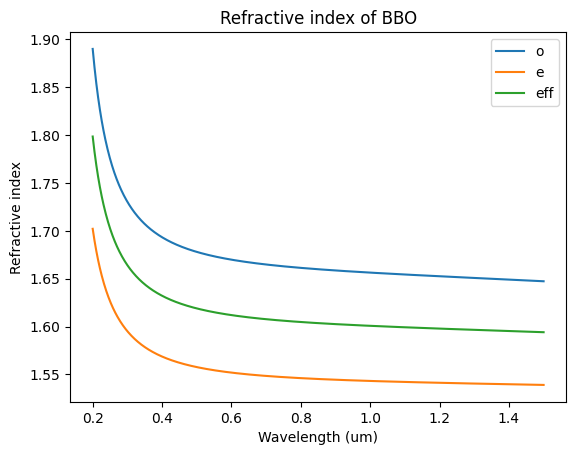

In [27]:
# plot the refractive index of BBO 
wavelength = np.linspace(0.2, 1.5, 1000)
n_o = bbo_sellmeier_n(wavelength, 'o')
n_e = bbo_sellmeier_n(wavelength, 'e')
n_eff = bbo_sellmeier_n_eff(wavelength)
plt.plot(wavelength, n_o)
plt.plot(wavelength, n_e)
plt.plot(wavelength, n_eff)
plt.legend(['o', 'e', 'eff'])
plt.xlabel('Wavelength (um)')
plt.ylabel('Refractive index')
plt.title('Refractive index of BBO')
plt.show()

In [28]:
i_wavelengths = np.linspace(0.725, 0.825, 1000)

# Without Compensation

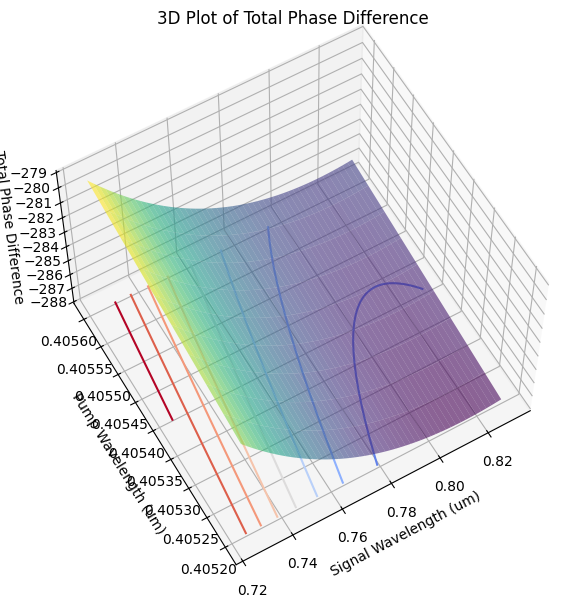

In [37]:
# Use lengths from the paper
l_yvo_pre, l_yvo_post = (0, 0)

l_bbo_pre = 13e3
l_bbo_post = 13.7e3

# Define polarization states
a = 'o'
aprime = 'e'
b = 'e'
bprime = 'o'

# Generate data for 3D plot
pump_wavelengths = np.linspace(0.4052, 0.4056, 10)
s_wavelengths = np.linspace(0.725, 0.83, 1000)
X, Y = np.meshgrid(s_wavelengths, pump_wavelengths)
Z = np.zeros_like(X)

for i, pump_wavelength in enumerate(pump_wavelengths):
    s_wavelengths = 1 / (1 / pump_wavelength - 1 / i_wavelengths)
    
    n_a_yvo_p = yvo_sellmeier_n(pump_wavelength, a)
    n_o_bbo_p = bbo_sellmeier_n(pump_wavelength, "o")
    n_eff_bbo_i = bbo_sellmeier_n_eff(i_wavelengths)
    n_eff_bbo_s = bbo_sellmeier_n_eff(s_wavelengths)
    n_b_yvo_i = yvo_sellmeier_n(i_wavelengths, b)
    n_b_yvo_s = yvo_sellmeier_n(s_wavelengths, b)
    n_aprime_yvo_p = yvo_sellmeier_n(pump_wavelength, aprime)
    n_eff_bbo_p = bbo_sellmeier_n_eff(pump_wavelength)
    n_o_bbo_i = bbo_sellmeier_n(i_wavelengths, "o")
    n_o_bbo_s = bbo_sellmeier_n(s_wavelengths, "o")
    n_bprime_yvo_i = yvo_sellmeier_n(i_wavelengths, bprime)
    n_bprime_yvo_s = yvo_sellmeier_n(s_wavelengths, bprime)

    phase_h = 2 * np.pi * (
        l_yvo_pre  * n_a_yvo_p   / pump_wavelength + 
        l_bbo_pre  * n_o_bbo_p   / pump_wavelength +
        l_bbo_post * n_eff_bbo_i / i_wavelengths +
        l_bbo_post * n_eff_bbo_s / s_wavelengths +
        l_yvo_post * n_b_yvo_i   / i_wavelengths +
        l_yvo_post * n_b_yvo_s   / s_wavelengths
    )

    phase_v = 2 * np.pi * (
        l_yvo_pre  * n_aprime_yvo_p / pump_wavelength + 
        l_bbo_pre  * n_eff_bbo_p    / pump_wavelength +
        l_bbo_post * n_o_bbo_i      / i_wavelengths +
        l_bbo_post * n_o_bbo_s      / s_wavelengths +
        l_yvo_post * n_bprime_yvo_i / i_wavelengths +
        l_yvo_post * n_bprime_yvo_s / s_wavelengths
    )
    
    Z[i, :] = phase_v - phase_h

# Create 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6)
ax.set_xlabel("Signal Wavelength (um)")
ax.set_ylabel("Pump Wavelength (um)")
ax.set_zlabel("Total Phase Difference")
ax.set_title("3D Plot of Total Phase Difference")
ax.contour(X, Y, Z, levels=np.arange(Z.min(), Z.max(), 1), cmap='coolwarm', offset=Z.min())

z_range = Z.max() - Z.min()

# set the viewing angle
ax.view_init(60, 240)

plt.show()


# Adding Compensation

## YVO4 Lengths As In Paper

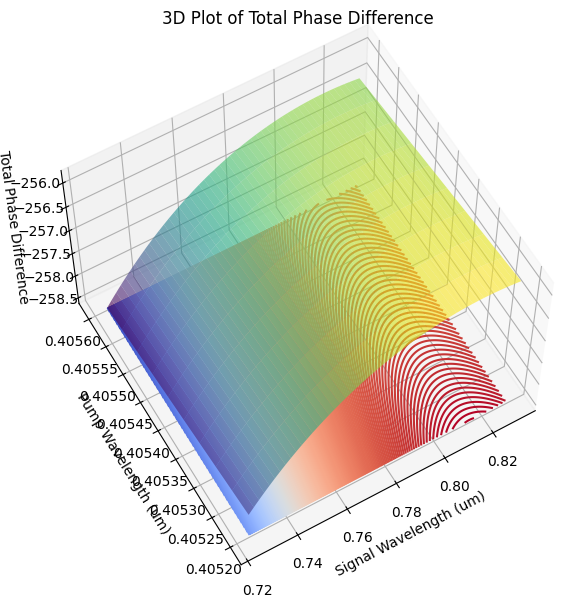

In [30]:
# Use lengths from the paper
l_yvo_pre, l_yvo_post = (0.78e3, 0.97e3)

l_bbo_pre = 13e3
l_bbo_post = 13.7e3

# Define polarization states
a = 'o'
aprime = 'e'
b = 'e'
bprime = 'o'

# Generate data for 3D plot
pump_wavelengths = np.linspace(0.4052, 0.4056, 10)
s_wavelengths = np.linspace(0.725, 0.83, 1000)
X, Y = np.meshgrid(s_wavelengths, pump_wavelengths)
Z = np.zeros_like(X)

for i, pump_wavelength in enumerate(pump_wavelengths):
    s_wavelengths = 1 / (1 / pump_wavelength - 1 / i_wavelengths)
    
    n_a_yvo_p = yvo_sellmeier_n(pump_wavelength, a)
    n_o_bbo_p = bbo_sellmeier_n(pump_wavelength, "o")
    n_eff_bbo_i = bbo_sellmeier_n_eff(i_wavelengths)
    n_eff_bbo_s = bbo_sellmeier_n_eff(s_wavelengths)
    n_b_yvo_i = yvo_sellmeier_n(i_wavelengths, b)
    n_b_yvo_s = yvo_sellmeier_n(s_wavelengths, b)
    n_aprime_yvo_p = yvo_sellmeier_n(pump_wavelength, aprime)
    n_eff_bbo_p = bbo_sellmeier_n_eff(pump_wavelength)
    n_o_bbo_i = bbo_sellmeier_n(i_wavelengths, "o")
    n_o_bbo_s = bbo_sellmeier_n(s_wavelengths, "o")
    n_bprime_yvo_i = yvo_sellmeier_n(i_wavelengths, bprime)
    n_bprime_yvo_s = yvo_sellmeier_n(s_wavelengths, bprime)

    phase_h = 2 * np.pi * (
        l_yvo_pre  * n_a_yvo_p   / pump_wavelength + 
        l_bbo_pre  * n_o_bbo_p   / pump_wavelength +
        l_bbo_post * n_eff_bbo_i / i_wavelengths +
        l_bbo_post * n_eff_bbo_s / s_wavelengths +
        l_yvo_post * n_b_yvo_i   / i_wavelengths +
        l_yvo_post * n_b_yvo_s   / s_wavelengths
    )

    phase_v = 2 * np.pi * (
        l_yvo_pre  * n_aprime_yvo_p / pump_wavelength + 
        l_bbo_pre  * n_eff_bbo_p    / pump_wavelength +
        l_bbo_post * n_o_bbo_i      / i_wavelengths +
        l_bbo_post * n_o_bbo_s      / s_wavelengths +
        l_yvo_post * n_bprime_yvo_i / i_wavelengths +
        l_yvo_post * n_bprime_yvo_s / s_wavelengths
    )
    
    Z[i, :] = phase_v - phase_h

# Create 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6)
ax.set_xlabel("Signal Wavelength (um)")
ax.set_ylabel("Pump Wavelength (um)")
ax.set_zlabel("Total Phase Difference")
ax.set_title("3D Plot of Total Phase Difference")
ax.contour(X, Y, Z, levels=np.arange(Z.min(), Z.max(), 0.01), cmap='coolwarm', offset=Z.min())

z_range = Z.max() - Z.min()

# set the viewing angle
ax.view_init(60, 240)

plt.show()


## Optimiser

In [35]:
# optimise to minimise the range over the yvo lengths

def objective(x):
    l_yvo_pre, l_yvo_post = x
    l_bbo_pre = 13e3
    l_bbo_post = 13.7e3

    # Define polarization states
    a = 'o'
    aprime = 'e'
    b = 'e'
    bprime = 'o'

    # Generate data for 3D plot
    pump_wavelengths = np.linspace(0.4052, 0.4056, 10)
    s_wavelengths = np.linspace(0.725, 0.825, 1000)
    X, Y = np.meshgrid(s_wavelengths, pump_wavelengths)
    Z = np.zeros_like(X)

    for i, pump_wavelength in enumerate(pump_wavelengths):
        s_wavelengths = 1 / (1 / pump_wavelength - 1 / i_wavelengths)
        
        n_a_yvo_p = yvo_sellmeier_n(pump_wavelength, a)
        n_o_bbo_p = bbo_sellmeier_n(pump_wavelength, "o")
        n_eff_bbo_i = bbo_sellmeier_n_eff(i_wavelengths)
        n_eff_bbo_s = bbo_sellmeier_n_eff(s_wavelengths)
        n_b_yvo_i = yvo_sellmeier_n(i_wavelengths, b)
        n_b_yvo_s = yvo_sellmeier_n(s_wavelengths, b)
        n_aprime_yvo_p = yvo_sellmeier_n(pump_wavelength, aprime)
        n_eff_bbo_p = bbo_sellmeier_n_eff(pump_wavelength)
        n_o_bbo_i = bbo_sellmeier_n(i_wavelengths, "o")
        n_o_bbo_s = bbo_sellmeier_n(s_wavelengths, "o")
        n_bprime_yvo_i = yvo_sellmeier_n(i_wavelengths, bprime)
        n_bprime_yvo_s = yvo_sellmeier_n(s_wavelengths, bprime)

        phase_h = 2 * np.pi * (
            l_yvo_pre  * n_a_yvo_p   / pump_wavelength + 
            l_bbo_pre  * n_o_bbo_p   / pump_wavelength +
            l_bbo_post * n_eff_bbo_i / i_wavelengths +
            l_bbo_post * n_eff_bbo_s / s_wavelengths +
            l_yvo_post * n_b_yvo_i   / i_wavelengths +
            l_yvo_post * n_b_yvo_s   / s_wavelengths
        )

        phase_v = 2 * np.pi * (
            l_yvo_pre  * n_aprime_yvo_p / pump_wavelength + 
            l_bbo_pre  * n_eff_bbo_p    / pump_wavelength +
            l_bbo_post * n_o_bbo_i      / i_wavelengths +
            l_bbo_post * n_o_bbo_s      / s_wavelengths +
            l_yvo_post * n_bprime_yvo_i / i_wavelengths +
            l_yvo_post * n_bprime_yvo_s / s_wavelengths
        )
        
        Z[i, :] = phase_v - phase_h

    z_range = Z.max() - Z.min()

    return z_range

# pass the objective function to the minimiser
result = minimize(objective, [0.745e3, 0.95e3], method='Nelder-Mead')

# get the optimal lengths
l_yvo_pre, l_yvo_post = result.x

# print in mm
print(f"Optimal YVO4 lengths: {l_yvo_pre/1e3:.3f} mm, {l_yvo_post/1e3:.3f} mm")

Optimal YVO4 lengths: 0.597 mm, 0.736 mm


## Optimal YVO4 Lengths

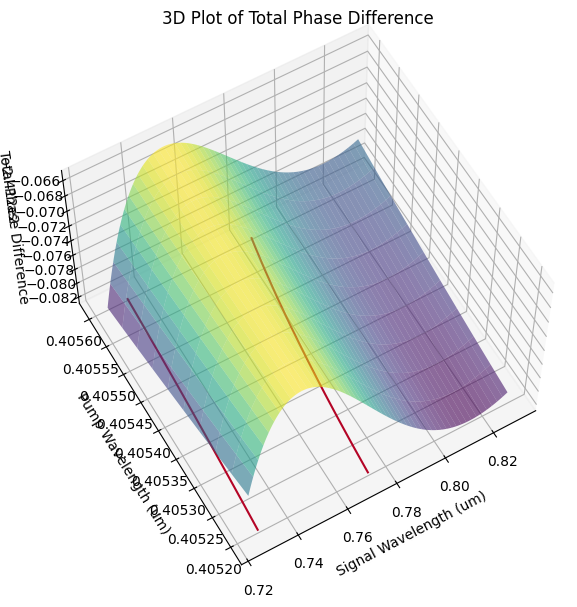

In [32]:
# Use the optimal lengths to generate the 3D plot

l_bbo_pre = 13e3
l_bbo_post = 13.7e3

# Define polarization states
a = 'o'
aprime = 'e'
b = 'e'
bprime = 'o'

# Generate data for 3D plot
pump_wavelengths = np.linspace(0.4052, 0.4056, 10)
s_wavelengths = np.linspace(0.725, 0.83, 1000)
X, Y = np.meshgrid(s_wavelengths, pump_wavelengths)
Z = np.zeros_like(X)

for i, pump_wavelength in enumerate(pump_wavelengths):
    s_wavelengths = 1 / (1 / pump_wavelength - 1 / i_wavelengths)
    
    n_a_yvo_p = yvo_sellmeier_n(pump_wavelength, a)
    n_o_bbo_p = bbo_sellmeier_n(pump_wavelength, "o")
    n_eff_bbo_i = bbo_sellmeier_n_eff(i_wavelengths)
    n_eff_bbo_s = bbo_sellmeier_n_eff(s_wavelengths)
    n_b_yvo_i = yvo_sellmeier_n(i_wavelengths, b)
    n_b_yvo_s = yvo_sellmeier_n(s_wavelengths, b)
    n_aprime_yvo_p = yvo_sellmeier_n(pump_wavelength, aprime)
    n_eff_bbo_p = bbo_sellmeier_n_eff(pump_wavelength)
    n_o_bbo_i = bbo_sellmeier_n(i_wavelengths, "o")
    n_o_bbo_s = bbo_sellmeier_n(s_wavelengths, "o")
    n_bprime_yvo_i = yvo_sellmeier_n(i_wavelengths, bprime)
    n_bprime_yvo_s = yvo_sellmeier_n(s_wavelengths, bprime)

    phase_h = 2 * np.pi * (
        l_yvo_pre  * n_a_yvo_p   / pump_wavelength + 
        l_bbo_pre  * n_o_bbo_p   / pump_wavelength +
        l_bbo_post * n_eff_bbo_i / i_wavelengths +
        l_bbo_post * n_eff_bbo_s / s_wavelengths +
        l_yvo_post * n_b_yvo_i   / i_wavelengths +
        l_yvo_post * n_b_yvo_s   / s_wavelengths
    )

    phase_v = 2 * np.pi * (
        l_yvo_pre  * n_aprime_yvo_p / pump_wavelength + 
        l_bbo_pre  * n_eff_bbo_p    / pump_wavelength +
        l_bbo_post * n_o_bbo_i      / i_wavelengths +
        l_bbo_post * n_o_bbo_s      / s_wavelengths +
        l_yvo_post * n_bprime_yvo_i / i_wavelengths +
        l_yvo_post * n_bprime_yvo_s / s_wavelengths
    )
    
    Z[i, :] = phase_v - phase_h

# Create 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6)
ax.set_xlabel("Signal Wavelength (um)")
ax.set_ylabel("Pump Wavelength (um)")
ax.set_zlabel("Total Phase Difference")
ax.set_title("3D Plot of Total Phase Difference")
ax.contour(X, Y, Z, levels=np.arange(Z.min(), Z.max(), 0.01), cmap='coolwarm', offset=Z.min())

z_range = Z.max() - Z.min()

# set the viewing angle
ax.view_init(60, 240)

plt.show()
